In [22]:
from collections.abc import Sequence
from sklearn import preprocessing
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shutil
import os


# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)


# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_


# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd


# Convert all missing values in the specified column to the median
def missing_median(df, name):
    med = df[name].median()
    df[name] = df[name].fillna(med)


# Convert all missing values in the specified column to the default
def missing_default(df, name, default_value):
    df[name] = df[name].fillna(default_value)


# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column. 
    target_type = df[target].dtypes
    target_type = target_type[0] if isinstance(target_type, Sequence) else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df[result].values.astype(np.float32), dummies.values.astype(np.float32)
    else:
        # Regression
        return df[result].values.astype(np.float32), df[target].values.astype(np.float32)

# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)


# Regression chart.
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()

# Remove all rows where the specified column is +/- sd standard deviations
def remove_outliers(df, name, sd):
    drop_rows = df.index[(np.abs(df[name] - df[name].mean()) >= (sd * df[name].std()))]
    df.drop(drop_rows, axis=0, inplace=True)


# Encode a column to a range between normalized_low and normalized_high.
def encode_numeric_range(df, name, normalized_low=-1, normalized_high=1,
                         data_low=None, data_high=None):
    if data_low is None:
        data_low = min(df[name])
        data_high = max(df[name])

    df[name] = ((df[name] - data_low) / (data_high - data_low)) * (normalized_high - normalized_low) + normalized_low


In [2]:
business = pd.read_json('yelp/yelp_academic_dataset_business.json', lines=True, nrows=1000000)

In [3]:
business.shape

(150346, 14)

In [4]:
business.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,Pns2l4eNsfO8kk83dixA6A,"Abby Rappoport, LAC, CMQ","1616 Chapala St, Ste 2",Santa Barbara,CA,93101,34.426679,-119.711197,5.0,7,0,{'ByAppointmentOnly': 'True'},"Doctors, Traditional Chinese Medicine, Naturop...",None
1,mpf3x-BjTdTEA3yCZrAYPw,The UPS Store,87 Grasso Plaza Shopping Center,Affton,MO,63123,38.551126,-90.335695,3.0,15,1,{'BusinessAcceptsCreditCards': 'True'},"Shipping Centers, Local Services, Notaries, Ma...","{'Monday': '0:0-0:0', 'Tuesday': '8:0-18:30', ..."
2,tUFrWirKiKi_TAnsVWINQQ,Target,5255 E Broadway Blvd,Tucson,AZ,85711,32.223236,-110.880452,3.5,22,0,"{'BikeParking': 'True', 'BusinessAcceptsCredit...","Department Stores, Shopping, Fashion, Home & G...","{'Monday': '8:0-22:0', 'Tuesday': '8:0-22:0', ..."
3,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80,1,"{'RestaurantsDelivery': 'False', 'OutdoorSeati...","Restaurants, Food, Bubble Tea, Coffee & Tea, B...","{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ..."
4,mWMc6_wTdE0EUBKIGXDVfA,Perkiomen Valley Brewery,101 Walnut St,Green Lane,PA,18054,40.338183,-75.471659,4.5,13,1,"{'BusinessAcceptsCreditCards': 'True', 'Wheelc...","Brewpubs, Breweries, Food","{'Wednesday': '14:0-22:0', 'Thursday': '16:0-2..."


In [5]:
reviews = pd.read_json('yelp/yelp_academic_dataset_review.json', lines=True, nrows=1000000)

In [6]:
df_review_agg = reviews.groupby('business_id')['text'].sum()

In [7]:
df_review_agg.head()

business_id
--ZVrH2X2QXBFdCilbirsw    This place is sadly perm closed. I was hoping ...
--_9CAxgfXZmoFdNIRrhHA    It's a huge place. There's P.O. boxes big enou...
--_lZuj_WCGnDG6n0emlRg    Good deals to be had on liquidated designer cl...
--hF_3v1JmU9nlu4zfXJ8Q    Really excited to get healthier options on the...
--sXnWH9Xm6_NvIjyuA99w    Ich war das erste mal in Philadelphia und ich ...
Name: text, dtype: object

In [8]:
df_review_agg.shape

(27095,)

In [9]:
df_ready_for_sklearn = pd.DataFrame({'business_id': df_review_agg.index, 'all_reviews':
df_review_agg.values})

In [10]:
df_ready_for_sklearn.head()

,business_id,all_reviews
0,--ZVrH2X2QXBFdCilbirsw,This place is sadly perm closed. I was hoping ...
1,--_9CAxgfXZmoFdNIRrhHA,It's a huge place. There's P.O. boxes big enou...
2,--_lZuj_WCGnDG6n0emlRg,Good deals to be had on liquidated designer cl...
3,--hF_3v1JmU9nlu4zfXJ8Q,Really excited to get healthier options on the...
4,--sXnWH9Xm6_NvIjyuA99w,Ich war das erste mal in Philadelphia und ich ...


In [11]:
df_ready_for_sklearn.shape

(27095, 2)

In [12]:
business = business[business['review_count'] > 20]

In [13]:
business.shape


(59699, 14)

In [14]:
business.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
2,tUFrWirKiKi_TAnsVWINQQ,Target,5255 E Broadway Blvd,Tucson,AZ,85711,32.223236,-110.880452,3.5,22,0,"{'BikeParking': 'True', 'BusinessAcceptsCredit...","Department Stores, Shopping, Fashion, Home & G...","{'Monday': '8:0-22:0', 'Tuesday': '8:0-22:0', ..."
3,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80,1,"{'RestaurantsDelivery': 'False', 'OutdoorSeati...","Restaurants, Food, Bubble Tea, Coffee & Tea, B...","{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ..."
12,il_Ro8jwPlHresjw9EGmBg,Denny's,8901 US 31 S,Indianapolis,IN,46227,39.637133,-86.127217,2.5,28,1,"{'RestaurantsReservations': 'False', 'Restaura...","American (Traditional), Restaurants, Diners, B...","{'Monday': '6:0-22:0', 'Tuesday': '6:0-22:0', ..."
14,0bPLkL0QhhPO5kt1_EXmNQ,Zio's Italian Market,2575 E Bay Dr,Largo,FL,33771,27.916116,-82.760461,4.5,100,0,"{'OutdoorSeating': 'False', 'RestaurantsGoodFo...","Food, Delis, Italian, Bakeries, Restaurants","{'Monday': '10:0-18:0', 'Tuesday': '10:0-20:0'..."
15,MUTTqe8uqyMdBl186RmNeA,Tuna Bar,205 Race St,Philadelphia,PA,19106,39.953949,-75.143226,4.0,245,1,"{'RestaurantsReservations': 'True', 'Restauran...","Sushi Bars, Restaurants, Japanese","{'Tuesday': '13:30-22:0', 'Wednesday': '13:30-..."


In [16]:
business.drop(['address', 'categories', 'city', 'state','attributes', 'hours', 'is_open', 'latitude', 'longitude', 'name', 'postal_code',], axis=1, inplace=True)

In [17]:
merged = pd.merge(business, df_ready_for_sklearn, on='business_id')

In [19]:
merged.head()

,business_id,stars,review_count,all_reviews
0,tUFrWirKiKi_TAnsVWINQQ,3.5,22,We are fans of Target. They seem to have a li...
1,MTSW4McQd7CbVtyjqoe9mw,4.0,80,This is nice little Chinese bakery in the hear...
2,il_Ro8jwPlHresjw9EGmBg,2.5,28,Went there at 4am and there was only one waitr...
3,0bPLkL0QhhPO5kt1_EXmNQ,4.5,100,The worst Chicken Parm. Sandwich I've ever eat...
4,MUTTqe8uqyMdBl186RmNeA,4.0,245,Stopped in to check out this new spot around t...


In [20]:
import sklearn.feature_extraction.text as sk_text
vectorizer = sk_text.TfidfVectorizer(max_features=2000,
                                     min_df=50)
matrix = vectorizer.fit_transform(merged.all_reviews)

In [21]:
vectorizer.get_feature_names_out()

array(['00', '10', '100', ..., 'yum', 'yummy', 'zero'], dtype=object)

In [74]:

import numpy as np
import tensorflow as tf

import os
from sklearn import metrics
from keras.models import Sequential
from keras.layers import Dense, Activation
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure, show
save_path = "./dnn"
tfidf = matrix.toarray()
stars = merged['stars'].values
x_train, x_test, y_train, y_test = train_test_split(tfidf, stars, test_size=0.20, random_state=42)
checkpointer = ModelCheckpoint(filepath ="./best_weights.hdf5", verbose=0, save_best_only=True)

model = Sequential()
model.add(Dense(20, input_dim = tfidf.shape[1], activation='relu'))
model.add(Dense(10))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=3, verbose=2, mode='auto')

model.fit(x_train, y_train, validation_data=(x_test, y_test), callbacks=[monitor, checkpointer], verbose=2, epochs=1000)

print('Training finished...Loading the best model')
print()
model.load_weights('./best_weights.hdf5')
#Predict
pred = model.predict(x_test)
#RMSE score
score = np.sqrt(metrics.mean_squared_error(pred, y_test))
print("RMSE score: {}".format(score))

model.save(os.path.join(save_path, "network.hdf5"))

Epoch 1/1000
288/288 - 0s - loss: 1.8621 - val_loss: 0.4031 - 471ms/epoch - 2ms/step
Epoch 2/1000
288/288 - 0s - loss: 0.2671 - val_loss: 0.1911 - 182ms/epoch - 633us/step
Epoch 3/1000
288/288 - 0s - loss: 0.1812 - val_loss: 0.1715 - 168ms/epoch - 584us/step
Epoch 4/1000
288/288 - 0s - loss: 0.1602 - val_loss: 0.1623 - 148ms/epoch - 514us/step
Epoch 5/1000
288/288 - 0s - loss: 0.1477 - val_loss: 0.1604 - 148ms/epoch - 514us/step
Epoch 6/1000
288/288 - 0s - loss: 0.1387 - val_loss: 0.1617 - 159ms/epoch - 553us/step
Epoch 7/1000
288/288 - 0s - loss: 0.1330 - val_loss: 0.1620 - 170ms/epoch - 591us/step
Epoch 8/1000
288/288 - 0s - loss: 0.1266 - val_loss: 0.1657 - 170ms/epoch - 591us/step
Epoch 8: early stopping
Training finished...Loading the best model

72/72 [==============================] - 0s 643us/step
RMSE score: 0.4004655006915573


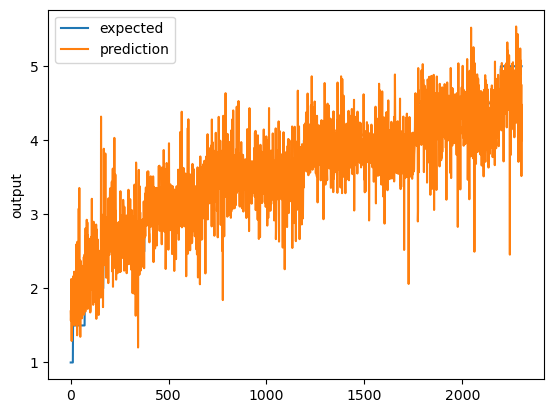

In [75]:
chart_regression(pred.flatten(),y_test, sort=True)

In [76]:
df_y = pd.DataFrame(merged.stars, columns = ['stars'])
df_pred = pd.DataFrame(pred, columns = ['predicted'])
df_y.head()

result = pd.concat([df_y, df_pred], axis = 1)
result.head()

,stars,predicted
0,3.5,3.176678
1,4.0,3.855871
2,2.5,1.608593
3,4.5,2.887215
4,4.0,3.617704


In [66]:
#RElu and SGD

In [78]:
save_path = "./dnn"
tfidf = matrix.toarray()
stars = merged['stars'].values
x_train, x_test, y_train, y_test = train_test_split(tfidf, stars, test_size=0.20, random_state=42)
checkpointer = ModelCheckpoint(filepath ="./best_weights.hdf5", verbose=0, save_best_only=True)

model = Sequential()
model.add(Dense(30, input_dim = tfidf.shape[1], activation='relu'))
model.add(Dense(20))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='sgd')
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=3, verbose=2, mode='auto')

model.fit(x_train, y_train, validation_data=(x_test, y_test), callbacks=[monitor, checkpointer], verbose=2, epochs=1000)

print('Training finished...Loading the best model')
print()
model.load_weights('./best_weights.hdf5')
#Predict
pred = model.predict(x_test)
#RMSE score
score = np.sqrt(metrics.mean_squared_error(pred, y_test))
print("RMSE score: {}".format(score))

model.save(os.path.join(save_path, "network.hdf5"))

Epoch 1/1000
288/288 - 1s - loss: 0.9340 - val_loss: 0.6327 - 622ms/epoch - 2ms/step
Epoch 2/1000
288/288 - 0s - loss: 0.5640 - val_loss: 0.5027 - 158ms/epoch - 549us/step
Epoch 3/1000
288/288 - 0s - loss: 0.4197 - val_loss: 0.3377 - 183ms/epoch - 634us/step
Epoch 4/1000
288/288 - 0s - loss: 0.3011 - val_loss: 0.2634 - 169ms/epoch - 588us/step
Epoch 5/1000
288/288 - 0s - loss: 0.2545 - val_loss: 0.2291 - 141ms/epoch - 490us/step
Epoch 6/1000
288/288 - 0s - loss: 0.2330 - val_loss: 0.2211 - 138ms/epoch - 478us/step
Epoch 7/1000
288/288 - 0s - loss: 0.2198 - val_loss: 0.2068 - 139ms/epoch - 484us/step
Epoch 8/1000
288/288 - 0s - loss: 0.2082 - val_loss: 0.2113 - 157ms/epoch - 545us/step
Epoch 9/1000
288/288 - 0s - loss: 0.2016 - val_loss: 0.2060 - 166ms/epoch - 577us/step
Epoch 10/1000
288/288 - 0s - loss: 0.1958 - val_loss: 0.1815 - 174ms/epoch - 606us/step
Epoch 11/1000
288/288 - 0s - loss: 0.1888 - val_loss: 0.1781 - 168ms/epoch - 583us/step
Epoch 12/1000
288/288 - 0s - loss: 0.1862 -

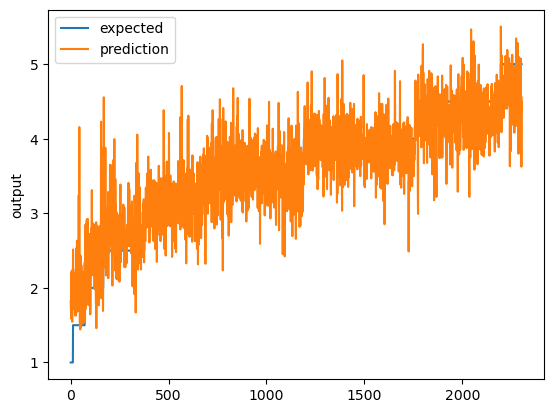

In [79]:
chart_regression(pred.flatten(),y_test, sort=True)

In [80]:
df_y = pd.DataFrame(merged.stars, columns = ['stars'])
df_pred = pd.DataFrame(pred, columns = ['predicted'])
df_y.head()

result = pd.concat([df_y, df_pred], axis = 1)
result.head()

,stars,predicted
0,3.5,2.930017
1,4.0,3.823811
2,2.5,1.826217
3,4.5,2.784048
4,4.0,3.586596


Sigmoid With Adam

In [81]:
save_path = "./dnn"
tfidf = matrix.toarray()
stars = merged['stars'].values
x_train, x_test, y_train, y_test = train_test_split(tfidf, stars, test_size=0.20, random_state=42)
checkpointer = ModelCheckpoint(filepath ="./best_weights.hdf5", verbose=0, save_best_only=True)

model = Sequential()
model.add(Dense(30, input_dim = tfidf.shape[1], activation='sigmoid'))
model.add(Dense(20))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=3, verbose=2, mode='auto')

model.fit(x_train, y_train, validation_data=(x_test, y_test), callbacks=[monitor, checkpointer], verbose=2, epochs=1000)

print('Training finished...Loading the best model')
print()
model.load_weights('./best_weights.hdf5')
#Predict
pred = model.predict(x_test)
#RMSE score
score = np.sqrt(metrics.mean_squared_error(pred, y_test))
print("RMSE score: {}".format(score))

model.save(os.path.join(save_path, "network.hdf5"))

Epoch 1/1000
288/288 - 0s - loss: 1.4413 - val_loss: 0.5098 - 381ms/epoch - 1ms/step
Epoch 2/1000
288/288 - 0s - loss: 0.3806 - val_loss: 0.2756 - 330ms/epoch - 1ms/step
Epoch 3/1000
288/288 - 0s - loss: 0.2268 - val_loss: 0.1921 - 337ms/epoch - 1ms/step
Epoch 4/1000
288/288 - 0s - loss: 0.1808 - val_loss: 0.1658 - 217ms/epoch - 753us/step
Epoch 5/1000
288/288 - 0s - loss: 0.1631 - val_loss: 0.1567 - 184ms/epoch - 639us/step
Epoch 6/1000
288/288 - 0s - loss: 0.1531 - val_loss: 0.1515 - 191ms/epoch - 663us/step
Epoch 7/1000
288/288 - 0s - loss: 0.1442 - val_loss: 0.1490 - 163ms/epoch - 566us/step
Epoch 8/1000
288/288 - 0s - loss: 0.1379 - val_loss: 0.1475 - 158ms/epoch - 548us/step
Epoch 9/1000
288/288 - 0s - loss: 0.1323 - val_loss: 0.1480 - 157ms/epoch - 544us/step
Epoch 10/1000
288/288 - 0s - loss: 0.1292 - val_loss: 0.1511 - 155ms/epoch - 537us/step
Epoch 11/1000
288/288 - 0s - loss: 0.1268 - val_loss: 0.1508 - 152ms/epoch - 528us/step
Epoch 11: early stopping
Training finished...Lo

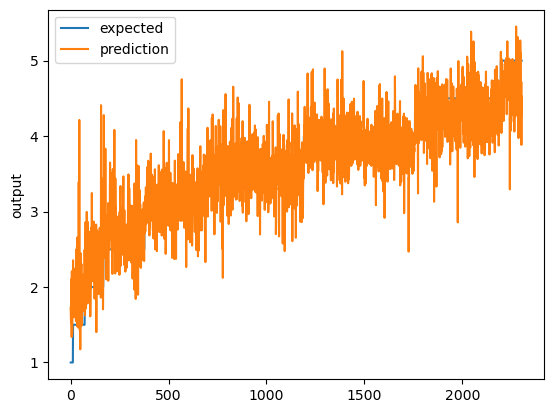

In [82]:
chart_regression(pred.flatten(),y_test, sort=True)

In [83]:
df_y = pd.DataFrame(merged.stars, columns = ['stars'])
df_pred = pd.DataFrame(pred, columns = ['predicted'])
df_y.head()

result = pd.concat([df_y, df_pred], axis = 1)
result.head()

,stars,predicted
0,3.5,3.104033
1,4.0,3.855316
2,2.5,1.489065
3,4.5,2.877041
4,4.0,3.563398


In [85]:
# Sigmoid with SGD
save_path = "./dnn"
tfidf = matrix.toarray()
stars = merged['stars'].values
x_train, x_test, y_train, y_test = train_test_split(tfidf, stars, test_size=0.20, random_state=42)
checkpointer = ModelCheckpoint(filepath ="./best_weights.hdf5", verbose=0, save_best_only=True)

model = Sequential()
model.add(Dense(30, input_dim = tfidf.shape[1], activation='sigmoid'))
model.add(Dense(20))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='sgd')
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=3, verbose=2, mode='auto')

model.fit(x_train, y_train, validation_data=(x_test, y_test), callbacks=[monitor, checkpointer], verbose=2, epochs=1000)

print('Training finished...Loading the best model')
print()
model.load_weights('./best_weights.hdf5')
#Predict
pred = model.predict(x_test)
#RMSE score
score = np.sqrt(metrics.mean_squared_error(pred, y_test))
print("RMSE score: {}".format(score))

model.save(os.path.join(save_path, "network.hdf5"))

Epoch 1/1000
288/288 - 1s - loss: 0.7688 - val_loss: 0.7079 - 517ms/epoch - 2ms/step
Epoch 2/1000
288/288 - 0s - loss: 0.6828 - val_loss: 0.6873 - 179ms/epoch - 620us/step
Epoch 3/1000
288/288 - 0s - loss: 0.6751 - val_loss: 0.6779 - 147ms/epoch - 512us/step
Epoch 4/1000
288/288 - 0s - loss: 0.6657 - val_loss: 0.6702 - 150ms/epoch - 520us/step
Epoch 5/1000
288/288 - 0s - loss: 0.6581 - val_loss: 0.6663 - 177ms/epoch - 614us/step
Epoch 6/1000
288/288 - 0s - loss: 0.6462 - val_loss: 0.6484 - 152ms/epoch - 527us/step
Epoch 7/1000
288/288 - 0s - loss: 0.6362 - val_loss: 0.6331 - 144ms/epoch - 501us/step
Epoch 8/1000
288/288 - 0s - loss: 0.6196 - val_loss: 0.6154 - 149ms/epoch - 518us/step
Epoch 9/1000
288/288 - 0s - loss: 0.6010 - val_loss: 0.6040 - 154ms/epoch - 536us/step
Epoch 10/1000
288/288 - 0s - loss: 0.5762 - val_loss: 0.5879 - 144ms/epoch - 499us/step
Epoch 11/1000
288/288 - 0s - loss: 0.5458 - val_loss: 0.5382 - 139ms/epoch - 483us/step
Epoch 12/1000
288/288 - 0s - loss: 0.5121 -

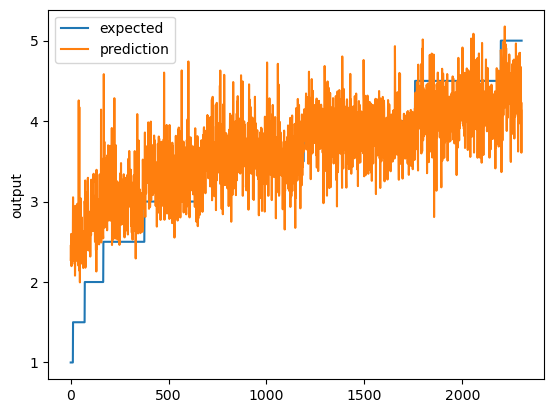

In [86]:
chart_regression(pred.flatten(),y_test, sort=True)

In [87]:
df_y = pd.DataFrame(merged.stars, columns = ['stars'])
df_pred = pd.DataFrame(pred, columns = ['predicted'])
df_y.head()

result = pd.concat([df_y, df_pred], axis = 1)
result.head()

,stars,predicted
0,3.5,2.893659
1,4.0,3.654878
2,2.5,2.688569
3,4.5,2.802314
4,4.0,3.504620


In [88]:
# tanh with adam
save_path = "./dnn"
tfidf = matrix.toarray()
stars = merged['stars'].values
x_train, x_test, y_train, y_test = train_test_split(tfidf, stars, test_size=0.20, random_state=42)
checkpointer = ModelCheckpoint(filepath ="./best_weights.hdf5", verbose=0, save_best_only=True)

model = Sequential()
model.add(Dense(30, input_dim = tfidf.shape[1], activation='tanh'))
model.add(Dense(20))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=3, verbose=2, mode='auto')

model.fit(x_train, y_train, validation_data=(x_test, y_test), callbacks=[monitor, checkpointer], verbose=2, epochs=1000)

print('Training finished...Loading the best model')
print()
model.load_weights('./best_weights.hdf5')
#Predict
pred = model.predict(x_test)
#RMSE score
score = np.sqrt(metrics.mean_squared_error(pred, y_test))
print("RMSE score: {}".format(score))

model.save(os.path.join(save_path, "network.hdf5"))

Epoch 1/1000
288/288 - 1s - loss: 1.0077 - val_loss: 0.2094 - 578ms/epoch - 2ms/step
Epoch 2/1000
288/288 - 0s - loss: 0.1885 - val_loss: 0.1698 - 183ms/epoch - 635us/step
Epoch 3/1000
288/288 - 0s - loss: 0.1577 - val_loss: 0.1651 - 170ms/epoch - 591us/step
Epoch 4/1000
288/288 - 0s - loss: 0.1424 - val_loss: 0.1696 - 155ms/epoch - 538us/step
Epoch 5/1000
288/288 - 0s - loss: 0.1348 - val_loss: 0.1721 - 156ms/epoch - 540us/step
Epoch 6/1000
288/288 - 0s - loss: 0.1289 - val_loss: 0.1724 - 159ms/epoch - 551us/step
Epoch 6: early stopping
Training finished...Loading the best model

72/72 [==============================] - 0s 401us/step
RMSE score: 0.4062637579646252


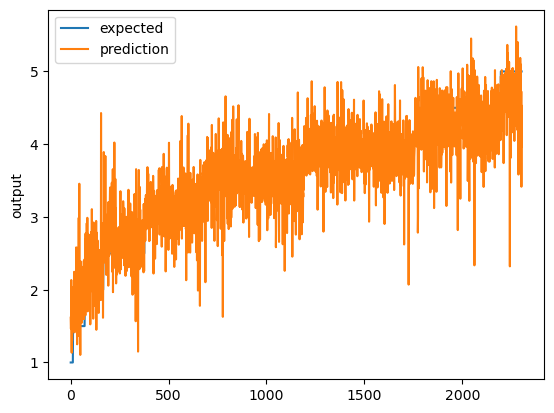

In [89]:
chart_regression(pred.flatten(),y_test, sort=True)

In [92]:
df_y = pd.DataFrame(merged.stars, columns = ['stars'])
df_pred = pd.DataFrame(pred, columns = ['predicted'])
df_y.head()
result = pd.concat([df_y, df_pred], axis = 1)
result.head()


,stars,predicted
0,3.5,3.143306
1,4.0,3.884277
2,2.5,1.544532
3,4.5,2.916602
4,4.0,3.656090


In [93]:
# tanh with sgd
save_path = "./dnn"
tfidf = matrix.toarray()
stars = merged['stars'].values
x_train, x_test, y_train, y_test = train_test_split(tfidf, stars, test_size=0.20, random_state=42)
checkpointer = ModelCheckpoint(filepath ="./best_weights.hdf5", verbose=0, save_best_only=True)

model = Sequential()
model.add(Dense(30, input_dim = tfidf.shape[1], activation='tanh'))
model.add(Dense(20))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='sgd')
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=3, verbose=2, mode='auto')

model.fit(x_train, y_train, validation_data=(x_test, y_test), callbacks=[monitor, checkpointer], verbose=2, epochs=1000)

print('Training finished...Loading the best model')
print()
model.load_weights('./best_weights.hdf5')
#Predict
pred = model.predict(x_test)
#RMSE score
score = np.sqrt(metrics.mean_squared_error(pred, y_test))
print("RMSE score: {}".format(score))

model.save(os.path.join(save_path, "network.hdf5"))

Epoch 1/1000
288/288 - 1s - loss: 0.8383 - val_loss: 0.6190 - 532ms/epoch - 2ms/step
Epoch 2/1000
288/288 - 0s - loss: 0.5072 - val_loss: 0.4376 - 215ms/epoch - 745us/step
Epoch 3/1000
288/288 - 0s - loss: 0.3477 - val_loss: 0.2772 - 174ms/epoch - 603us/step
Epoch 4/1000
288/288 - 0s - loss: 0.2662 - val_loss: 0.2573 - 155ms/epoch - 540us/step
Epoch 5/1000
288/288 - 0s - loss: 0.2370 - val_loss: 0.2074 - 157ms/epoch - 545us/step
Epoch 6/1000
288/288 - 0s - loss: 0.2210 - val_loss: 0.2020 - 155ms/epoch - 538us/step
Epoch 7/1000
288/288 - 0s - loss: 0.2109 - val_loss: 0.1925 - 153ms/epoch - 530us/step
Epoch 8/1000
288/288 - 0s - loss: 0.2013 - val_loss: 0.1826 - 155ms/epoch - 537us/step
Epoch 9/1000
288/288 - 0s - loss: 0.1994 - val_loss: 0.1923 - 158ms/epoch - 548us/step
Epoch 10/1000
288/288 - 0s - loss: 0.1885 - val_loss: 0.1783 - 140ms/epoch - 484us/step
Epoch 11/1000
288/288 - 0s - loss: 0.1863 - val_loss: 0.1712 - 142ms/epoch - 492us/step
Epoch 12/1000
288/288 - 0s - loss: 0.1819 -

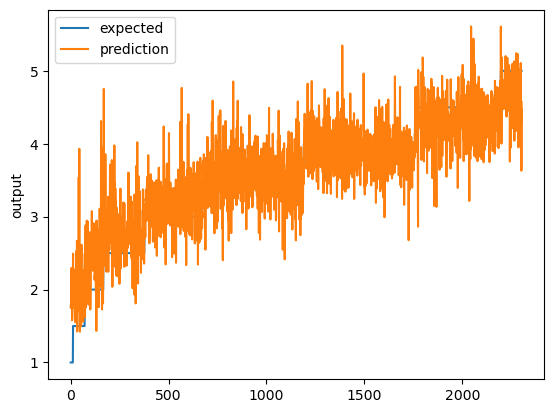

In [94]:
chart_regression(pred.flatten(),y_test, sort=True)


In [95]:
df_y = pd.DataFrame(merged.stars, columns = ['stars'])
df_pred = pd.DataFrame(pred, columns = ['predicted'])
df_y.head()
result = pd.concat([df_y, df_pred], axis = 1)
result.head()

,stars,predicted
0,3.5,2.895272
1,4.0,4.018091
2,2.5,2.030661
3,4.5,2.760025
4,4.0,3.475945
